<a href="https://colab.research.google.com/github/CLiz17/densenet-deepfake/blob/main/custom_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`Personalized Dataset : 500 real, 500 dfake`

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

def load_images_and_labels(fpath):
    images = []
    labels = []

    for image_name in os.listdir(fpath):
        image_path = os.path.join(fpath, image_name)
        img = cv2.imread(image_path)
        images.append(img)
        label = extract_label_from_filename(image_name)
        labels.append(label)

    return np.array(images), np.array(labels)

def extract_label_from_filename(filename):
    if "_1" in filename.lower():
        return 1
    elif "_0" in filename.lower():
        return 0

fpath = "/content/drive/MyDrive/dataset500"
images, labels = load_images_and_labels(fpath)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow(
    x_test,
    y_test,
    batch_size=32,
    subset='validation'
)

base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers[-15:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

model.save('model.h5')

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/20
23/23 [==============================] - 326s 12s/step - loss: 1.0325 - accuracy: 0.5350 - val_loss: 0.7131 - val_accuracy: 0.5682
Epoch 2/20
23/23 [==============================] - 274s 12s/step - loss: 0.8587 - accuracy: 0.6232 - val_loss: 0.6019 - val_accuracy: 0.6591
Epoch 3/20
23/23 [==============================] - 274s 12s/step - loss: 0.7788 - accuracy: 0.6429 - val_loss: 0.5927 - val_accuracy: 0.6818
Epoch 4/20
23/23 [==============================] - 273s 12s/step - loss: 0.7316 - accuracy: 0.6583 - val_loss: 0.5626 - val_accuracy: 0.7045
Epoch 5/20
23/23 [==============================] - 261s 11s/step - loss: 0.7226 - accuracy: 0.6625 - val_loss: 0.4209 - val_accuracy: 0.7727
Epoch 6/20
23/23 [==============================] - 261s 11s/step - loss: 0.5974 - accuracy: 0.7353 - val_loss: 0.3872 - val_accuracy: 0.8864
Epoch 7/20
23/23 [==============================] - 276s 12s/step - loss: 0.5529 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


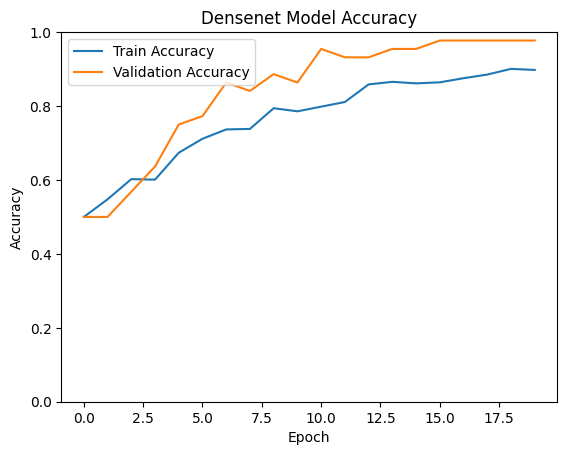

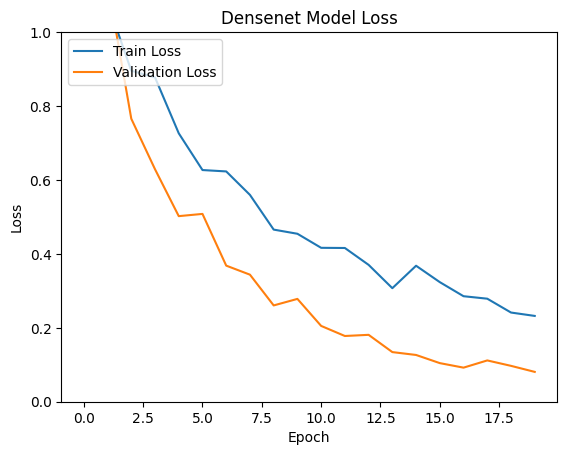

7/7 [==============================] - 32s 4s/step


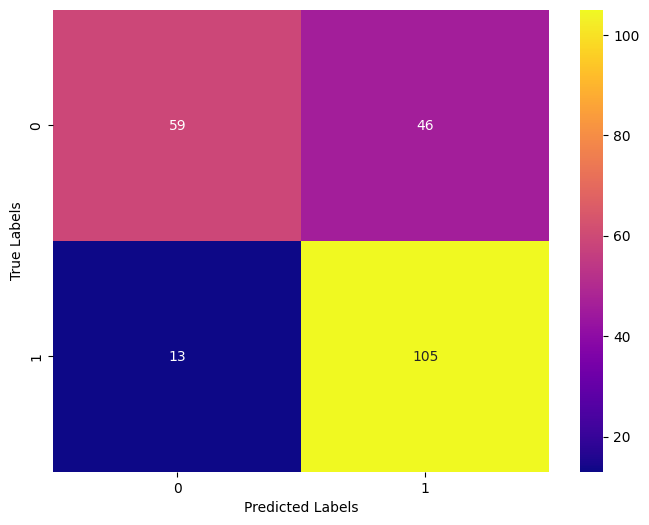

Sensitivity: 0.7
Specificity: 0.82
Accuracy: 0.74
Precision: 0.89
F1 Score: 0.78


In [ ]:
# Graphs
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.show()

# Confusion Matrix
x_test_resized = tf.image.resize(x_test, (224, 224))
y_pred = model.predict(x_test_resized) > 0.5

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="plasma", fmt="d", annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate metrics
def calculate_metrics(cm):
    TN = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TP = cm[1, 1]

    sensitivity = round((TP / (TP + FN)), 2) if (TP + FN) > 0 else 0
    specificity = round((TN / (TN + FP)), 2) if (TN + FP) > 0 else 0
    accuracy = round(((TP + TN) / (TP + TN + FP + FN)), 2)
    precision = round((TP / (TP + FP)), 2) if (TP + FP) > 0 else 0
    f1_score = round((2 * (precision * sensitivity) / (precision + sensitivity)), 2) if (precision + sensitivity) > 0 else 0

    return sensitivity, specificity, accuracy, precision, f1_score

sensitivity, specificity, accuracy, precision, f1_score = calculate_metrics(cm)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

In [ ]:
# Calculate metrics
def calculate_metrics(cm):
    TN = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TP = cm[1, 1]

    sensitivity = round((TP / (TP + FN)), 3) if (TP + FN) > 0 else 0
    specificity = round((TN / (TN + FP)), 3) if (TN + FP) > 0 else 0
    accuracy = round(((TP + TN) / (TP + TN + FP + FN)), 3)
    precision = round((TP / (TP + FP)), 3) if (TP + FP) > 0 else 0
    f1_score = round((2 * (precision * sensitivity) / (precision + sensitivity)), 3) if (precision + sensitivity) > 0 else 0

    return sensitivity, specificity, accuracy, precision, f1_score

sensitivity, specificity, accuracy, precision, f1_score = calculate_metrics(cm)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

Sensitivity: 0.695
Specificity: 0.819
Accuracy: 0.735
Precision: 0.89
F1 Score: 0.781


In [ ]:
# Testing - Untrained Dataset
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from IPython.display import display
from sklearn.metrics import confusion_matrix, classification_report
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

model = load_model("/content/model.h5")

def load_images_and_labels(fpath):
    images = []
    labels = []

    for image_name in os.listdir(fpath):
        image_path = os.path.join(fpath, image_name)
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, (224, 224))
        images.append(img_resized)
        label = extract_label_from_filename(image_name)
        labels.append(label)

    return np.array(images), np.array(labels)

def extract_label_from_filename(filename):
    if "dfake" in filename.lower():
        return 1
    elif "real" in filename.lower():
        return 0

test_images, true_labels = load_images_and_labels("/content/drive/MyDrive/kaggle-dataset/df")

predicted_labels = []

for img in test_images:
    prediction = model.predict(np.expand_dims(img, axis=0))
    predicted_label = 1 if prediction > 0.5 else 0
    predicted_labels.append(predicted_label)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="plasma", fmt="d", annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
def calculate_metrics(cm):
    TN = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TP = cm[1, 1]

    sensitivity = round((TP / (TP + FN)), 3) if (TP + FN) > 0 else 0
    specificity = round((TN / (TN + FP)), 3) if (TN + FP) > 0 else 0
    accuracy = round(((TP + TN) / (TP + TN + FP + FN)), 3)
    precision = round((TP / (TP + FP)), 3) if (TP + FP) > 0 else 0
    f1_score = round((2 * (precision * sensitivity) / (precision + sensitivity)), 3) if (precision + sensitivity) > 0 else 0

    return sensitivity, specificity, accuracy, precision, f1_score

sensitivity, specificity, accuracy, precision, f1_score = calculate_metrics(cm)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

# Displaying a few images with prediction results
for i in range(10):
    img = test_images[i]
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]
    prediction_prob = model.predict(np.expand_dims(img, axis=0))[0][0]

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    if predicted_label == 1:
        prediction = 'Deepfake'
    else:
        prediction = 'Real'

    if true_label == 1:
        true = 'Deepfake'
    else:
        true = 'Real'

    plt.title(f"True: {true}\nPredicted: {prediction}\nConfidence: {prediction_prob:.4f}")
    plt.show()